In [1]:
import numpy as np
import torch
from torchvision.datasets import Cityscapes
import os
from glob import glob
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import cv2
from PIL import Image
import imageio
from einops import rearrange
from torchvision import transforms
from torchvision.io import read_image
import torchvision
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from labels import id2label, label2id, id2color
from Lane_Detection.lane_detection import LaneDetector
import matplotlib.image as mimg

## Define Image Utils

In [2]:
def merge_images(image1, image2):
    """
    Takes two images represented by NumPy arrays and returns a new image created by placing the original images side-by-side.
    
    Args:
    image1 (np.array): NumPy array of the first image.
    image2 (np.array): NumPy array of the second image.
    
    Returns:
    np.array: NumPy array of the merged image.
    """
    # Convert the input arrays to PIL Images
    pil_image1 = Image.fromarray(image1)
    pil_image2 = Image.fromarray(image2)

    # Get the size of the input images
    width1, height1 = pil_image1.size
    width2, height2 = pil_image2.size

    # Determine the dimensions of the merged image
    merged_width = width1 + width2
    merged_height = max(height1, height2)

    # Create a new blank image with the appropriate dimensions
    merged_image = Image.new('RGB', (merged_width, merged_height))

    # Paste the first image on the left side of the new image
    merged_image.paste(pil_image1, (0, 0))

    # Paste the second image on the right side of the new image
    merged_image.paste(pil_image2, (width1, 0))

    # Convert the merged image back to a NumPy array and return it
    return np.array(merged_image)
def merge_images(image1, image2):
    return np.hstack([image1, image2])

In [43]:
def display_image_grid(image_list, grid_size=(2, 2)):
    """
    Takes a list of images and displays them as a grid.
    
    Args:
    image_list (list): List of NumPy arrays representing images.
    grid_size (tuple): Size of the grid in (rows, columns). Defaults to (2, 2).
    
    Returns:
    None
    """
    # Calculate the number of images and the grid dimensions
    num_images = len(image_list)
    num_rows, num_cols = grid_size
    assert num_rows * num_cols >= num_images, "Grid size is too small to fit all images"

    # Create a figure and axis objects
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10,10))
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    # Loop through the images and plot them in the appropriate axis
    for i, image in enumerate(image_list):
        row = i // num_cols
        col = i % num_cols
        ax[row][col].imshow(image)
        ax[row][col].axis("off")

    # Show the plot
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

In [9]:
def image_list_to_tensor(imgs):
    """
    Converts list of PIL images to tensors
    """
    transform = transforms.ToTensor()
    tensor_list = [ transform(img) for img in imgs]

    # Concatenate the list of tensors along the first dimension to create a tensor of shape (num_images, channels, height, width)
    return torch.stack(tensor_list, dim=0)

In [10]:
def image_list_to_nparray(imgs):
    nparray = []
    for img in imgs:
        nparray.append(np.array(img, dtype=np.int32))
    return np.array(nparray)

## Define Dataset

In [3]:
class ImageDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.image_list = os.listdir(data_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_list[idx])
        image = Image.open(img_path).convert('RGB')
        rgb_image = image.copy()
        if self.transform:
            image = self.transform(image)
        return image, np.array(rgb_image)
from segment_proj import test, DRNSeg

In [4]:
# im_dir = 'datasets/cityscapes/cityscapes/leftImg8bit/test/berlin'
# im_dir = 'datasets/llama_subset'
im_dir = 'datasets/small'
MODEL_PATH = "drn_d_22_cityscapes.pth"
phase = "test"

In [6]:
# Create normalization required for DRN
info = {"std": [0.1829540508368939, 0.18656561047509476, 0.18447508988480435], "mean": [0.29010095242892997, 0.32808144844279574, 0.28696394422942517]}
normalize = transforms.Normalize(mean=info['mean'], std=info['std'])

In [7]:
image_dataset = ImageDataset(data_dir=im_dir)
# Resize later. DRN was trained on the default size, so I imagine it'll work better
image_dataset.transform = transforms.Compose([transforms.ToTensor(), normalize])
image_loader = DataLoader(image_dataset, batch_size=1, shuffle=False)

## Load Model

In [5]:
single_model = DRNSeg("drn_d_22", 19, pretrained_model=None,
                          pretrained=False)

single_model.load_state_dict(torch.load(MODEL_PATH))
model = torch.nn.DataParallel(single_model).cuda()

# Run Modules

## Semantic Segmentation

In [8]:
# Outputs lists of PIL images
_, outputs, road_masks, inputs = test(image_loader, model, 19)

C:\Users\Josh\Documents\cs444\final_project\segment_proj.py:259: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image_var = Variable(image, requires_grad=False, volatile=True)
C:\Users\Josh\Documents\cs444\final_project\segment_proj.py:113: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(y), x
[2023-05-07 18:27:22,209 segment_proj.py:283 test] Eval: [0/19]	Time 2.468 (2.468)	Data 0.071 (0.071)	
[2023-05-07 18:27:22,378 segment_proj.py:283 test] Eval: [1/19]	Time 0.148 (1.308)	Data 0.066 (0.068)	
[2023-05-07 18:27:22,542 segment_proj.py:283 test] Eval: [2/19]	Time 0.131 (0.915)	Data 0.073 (0.070)	
[2023-05-07 18:27:22,689 segment_proj.py:283 test] Eval: [3/19]	Time 0.125 (0.718)	Data 0.070 (0.070)	
[2023-05-07 18:27:22,848 segment_proj.py:283 test] Eval: [4/19]	Time 0.132 (0.600)	Data 0.073 (0.070)	
[2023-05-07 18:27:23,003 segment_proj.py:2

In [11]:
road_masks = image_list_to_nparray(road_masks)
outputs = image_list_to_nparray(outputs)
inputs = image_list_to_nparray(inputs)

## Lane Detection

  0%|          | 0/19 [00:00<?, ?it/s]

idx: [0]


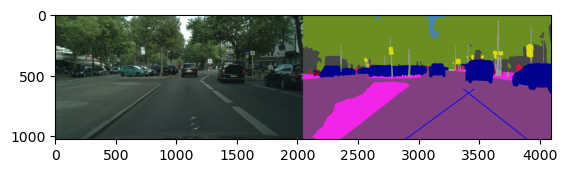

idx: [1]


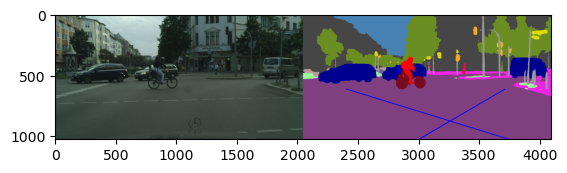

idx: [2]


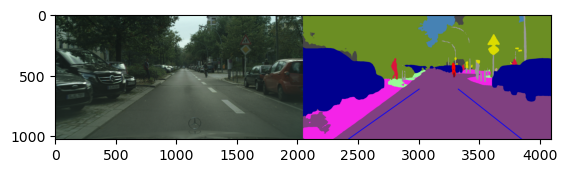

idx: [3]


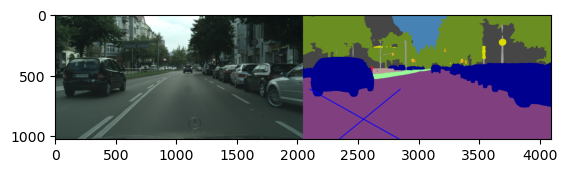

idx: [4]


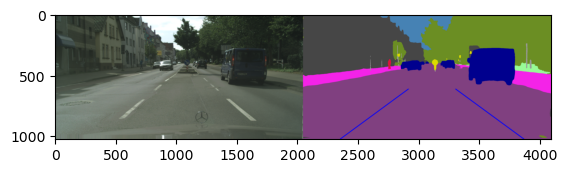

idx: [5]


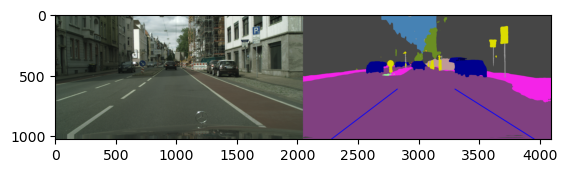

idx: [6]


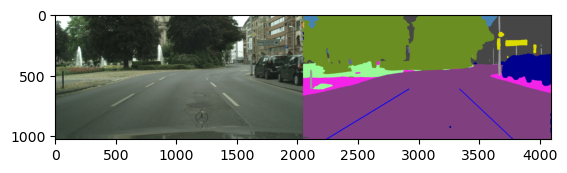

idx: [7]


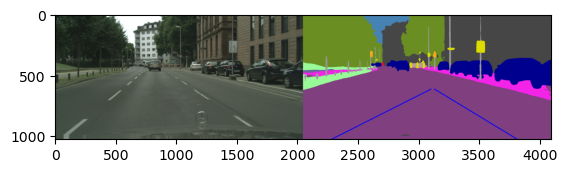

idx: [8]


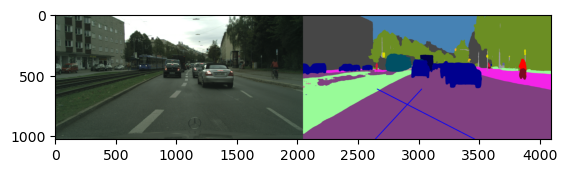

idx: [9]


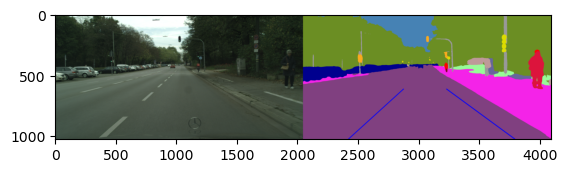

idx: [10]


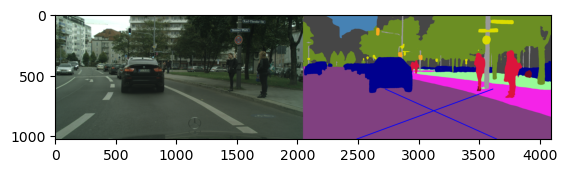

idx: [11]


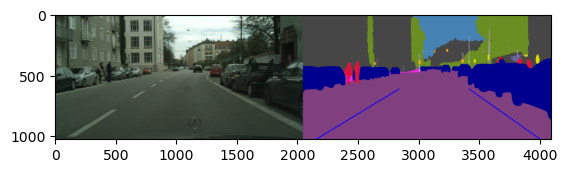

idx: [12]


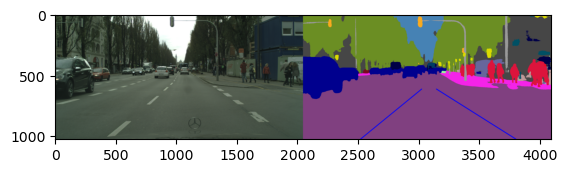

idx: [13]


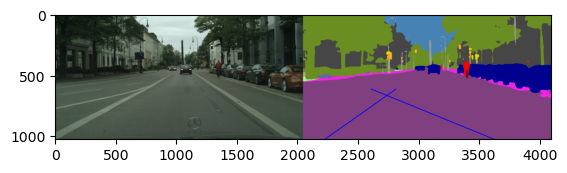

idx: [14]


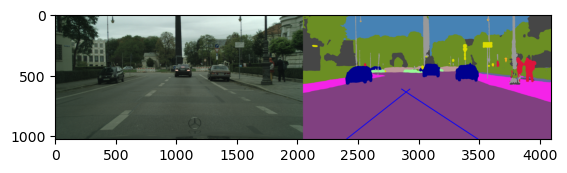

idx: [15]


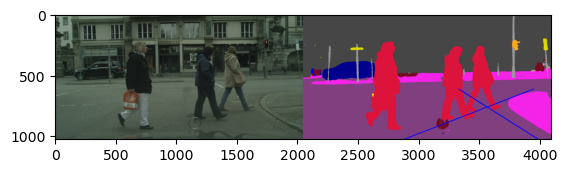

idx: [16]


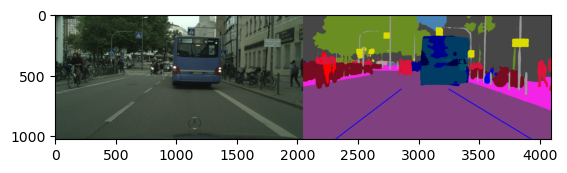

idx: [17]


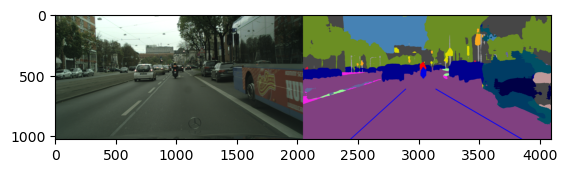

idx: [18]


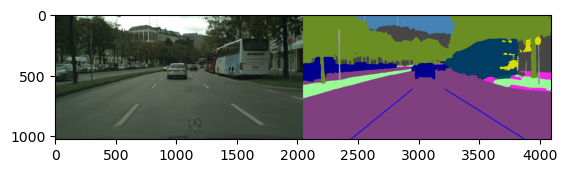

In [12]:
lane_and_segment_masks = []

for i in tqdm(range(len(inputs))):
    original = inputs[i]
    original_bgr = cv2.resize(original, (road_masks[i].shape[1], road_masks[i].shape[0]))
    image_bgr = cv2.cvtColor(inputs[i].astype(np.uint8), cv2.COLOR_RGB2BGR)
    resized_input = cv2.resize(image_bgr, (road_masks[i].shape[1], road_masks[i].shape[0]))
    resized_image_rgb = cv2.cvtColor(resized_input, cv2.COLOR_BGR2RGB)

    ld = LaneDetector(0.05, 0.09, 7, line_threshold=25, cropping_mask=np.array(road_masks[i], dtype=np.int32))
    lane_img, lines_xy = ld.detect_lanes(resized_input)

    out_mask = outputs[i].copy()
    cv2.line(out_mask, (lines_xy[0][0], lines_xy[0][1]), (lines_xy[0][2], lines_xy[0][3]), (0, 0, 255), 5)
    cv2.line(out_mask, (lines_xy[1][0], lines_xy[1][1]), (lines_xy[1][2], lines_xy[1][3]), (0, 0, 255), 5)

    lane_and_segment_masks.append(merge_images(original_bgr, out_mask))
    # To display:
    print(f"idx: [{i}]")
    plt.imshow(merge_images(original_bgr, out_mask))
    plt.show()


## Display Samples

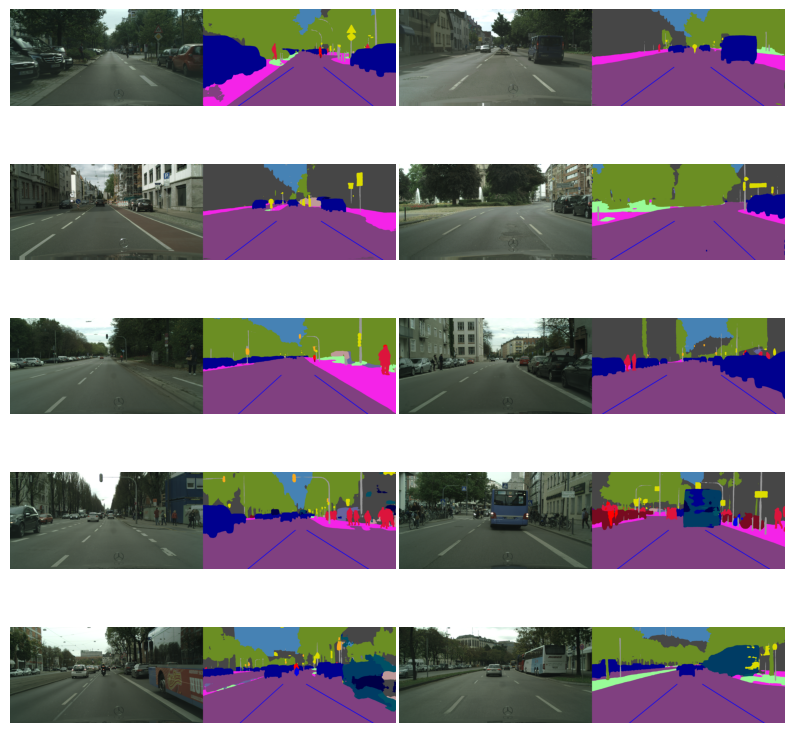

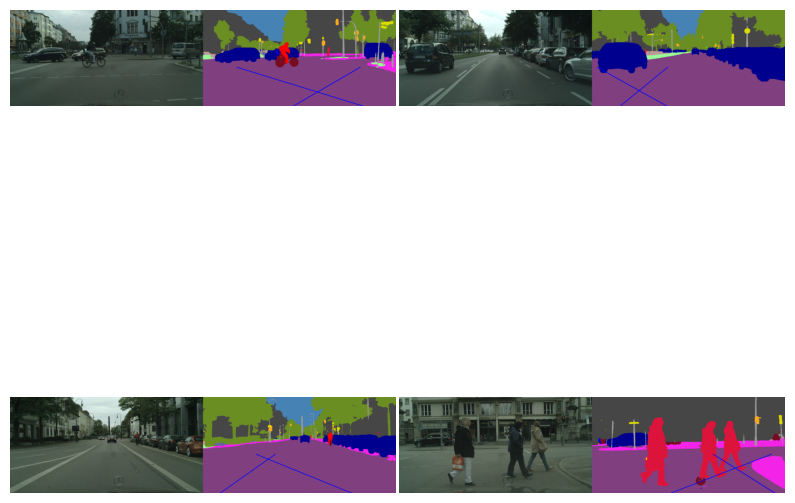

In [44]:
good_idxs = np.array([2, 4, 5, 6, 9, 11, 12, 16, 17, 18]).astype(int)
bad_idxs = np.array([1, 3, 13, 15])
display_image_grid(np.array(lane_and_segment_masks)[good_idxs], grid_size=(5,2))
display_image_grid(np.array(lane_and_segment_masks)[bad_idxs], grid_size=(2,2))